In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# 1) LOAD + SPLIT DATA
salary = pd.read_csv('https://github.com/ybifoundation/Dataset/raw/main/Salary%20Data.csv')

X = salary['Experience Years'].values.reshape(-1, 1).astype(np.float32)
y = salary['Salary'].values.astype(np.float32)

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_np)
y_train_tensor = torch.tensor(y_train_np)
X_test_tensor = torch.tensor(X_test_np)
y_test_tensor = torch.tensor(y_test_np)

# 2) DEFINE MODEL
model = nn.Linear(in_features=1, out_features=1)

# 3) LOSS + OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 4) TRAIN LOOP
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(1, num_epochs + 1):
    # -- Forward + Backprop on TRAIN set --
    y_pred_train = model(X_train_tensor).squeeze(-1)
    loss_train = criterion(y_pred_train, y_train_tensor)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # -- Evaluate on TEST set (no gradient) --
    # ====== Figure 1: TRAIN & TEST points + regression line ======
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).squeeze(-1)
        loss_test = criterion(y_pred_test, y_test_tensor)

    # -- Plot TRAIN & TEST points + line --
    # We'll combine train & test X for a single continuous line
    with torch.no_grad():
        X_all = torch.cat([X_train_tensor, X_test_tensor], dim=0)  # shape: (n_train + n_test, 1)
        X_all_sorted, idx = torch.sort(X_all, dim=0)              # sort for smooth line
        y_line_all = model(X_all_sorted).squeeze(-1)


    plt.figure(figsize=(6, 4))
    plt.scatter(X_train_tensor.numpy(), y_train_tensor.numpy(), label='Train Data', alpha=0.8)
    plt.scatter(X_test_tensor.numpy(), y_test_tensor.numpy(), label='Test Data', alpha=0.8)
    plt.plot(X_all_sorted.numpy(), y_line_all.numpy(), color='red', label='Model Prediction')

    plt.title(f'Epoch {epoch} | '
              f'Train Loss: {loss_train.item():.3f} | '
              f'Test Loss: {loss_test.item():.3f}')
    plt.xlabel('Experience Years')
    plt.ylabel('Salary')
    plt.legend()
    plt.show()


     # ====== Figure 2: Scatter of Prediction vs. Ground Truth on the Test set ======
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_tensor.numpy(), y_pred_test.numpy(), alpha=0.8, label='Pred vs Ground Truth')

    # Plot a reference line y=x for visual comparison
    min_val = min(y_test_tensor.min().item(), y_pred_test.min().item())
    max_val = max(y_test_tensor.max().item(), y_pred_test.max().item())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x line')

    plt.title(f'Epoch {epoch}: Test Predictions vs True')
    plt.xlabel('Ground Truth Salary')
    plt.ylabel('Predicted Salary')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch}: Train Loss = {loss_train.item():.4f}, Test Loss = {loss_test.item():.4f}")

    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())

# 5) FINAL EVALUATION
[w_param, b_param] = model.parameters()
print("\n===== Final Learned Parameters =====")
print(f"Weight (w) = {w_param.item():.3f}")
print(f"Bias   (b) = {b_param.item():.3f}")

model.eval()
with torch.no_grad():
    final_train_loss = criterion(model(X_train_tensor).squeeze(-1), y_train_tensor).item()
    final_test_loss  = criterion(model(X_test_tensor).squeeze(-1), y_test_tensor).item()

print(f"Final Train MSE: {final_train_loss:.3f}")
print(f"Final Test  MSE: {final_test_loss:.3f}")

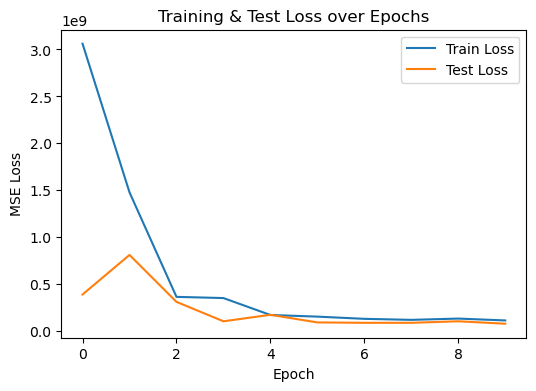

In [3]:
# plot the loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training & Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [ ]:

from torch.utils.data import TensorDataset, DataLoader


# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_np)
y_train_tensor = torch.tensor(y_train_np)
X_test_tensor = torch.tensor(X_test_np)
y_test_tensor = torch.tensor(y_test_np)

# Create TensorDataset for train, then DataLoader for mini-batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# ============================
# 2) DEFINE MODEL
# ============================
model = nn.Linear(in_features=1, out_features=1)

# ============================
# 3) LOSS + OPTIMIZER
# ============================
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# ============================
# 4) TRAIN LOOP (mini-batch)
# ============================
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()  # put model in training mode (good practice even for linear)
    
    # We'll accumulate training loss over mini-batches to compute an average
    train_loss_accum = 0.0
    batch_count = 0
    
    # ----- Mini-Batch Training -----
    for batch_X, batch_y in train_loader:
        # Forward pass
        y_pred_train = model(batch_X).squeeze(-1)
        loss_train = criterion(y_pred_train, batch_y)

        # Backprop + update
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Accumulate
        train_loss_accum += loss_train.item()
        batch_count += 1

    # Average train loss across mini-batches
    epoch_train_loss = train_loss_accum / batch_count

    # ----- Evaluate on TEST set (no gradient) -----
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).squeeze(-1)
        loss_test = criterion(y_pred_test, y_test_tensor)

    # ====== Figure 1: TRAIN & TEST points + regression line ======
    with torch.no_grad():
        # Combine + sort X for a continuous line
        X_all = torch.cat([X_train_tensor, X_test_tensor], dim=0)
        X_all_sorted, idx = torch.sort(X_all, dim=0)
        y_line_all = model(X_all_sorted).squeeze(-1)

    plt.figure(figsize=(6, 4))
    plt.scatter(X_train_tensor.numpy(), y_train_tensor.numpy(), label='Train Data', alpha=0.8)
    plt.scatter(X_test_tensor.numpy(), y_test_tensor.numpy(), label='Test Data', alpha=0.8)
    plt.plot(X_all_sorted.numpy(), y_line_all.numpy(), color='red', label='Model Prediction')

    plt.title(
        f'Epoch {epoch} | '
        f'Train Loss: {epoch_train_loss:.3f} | '
        f'Test Loss: {loss_test.item():.3f}'
    )
    plt.xlabel('Experience Years')
    plt.ylabel('Salary')
    plt.legend()
    plt.show()

    # ====== Figure 2: Predictions vs. Ground Truth on the TEST set ======
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_tensor.numpy(), y_pred_test.numpy(), alpha=0.8, label='Pred vs Ground Truth')

    # Reference line y = x
    min_val = min(y_test_tensor.min().item(), y_pred_test.min().item())
    max_val = max(y_test_tensor.max().item(), y_pred_test.max().item())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x line')

    plt.title(f'Epoch {epoch}: Test Predictions vs True')
    plt.xlabel('True Salary')
    plt.ylabel('Predicted Salary')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch} | Train Loss = {epoch_train_loss:.4f}, Test Loss = {loss_test.item():.4f}")
    train_losses.append(epoch_train_loss)
    test_losses.append(loss_test.item())

# ============================
# 5) FINAL EVALUATION
# ============================
[w_param, b_param] = model.parameters()
print("\n===== Final Learned Parameters =====")
print(f"Weight (w) = {w_param.item():.3f}")
print(f"Bias   (b) = {b_param.item():.3f}")

model.eval()
with torch.no_grad():
    final_train_pred = model(X_train_tensor).squeeze(-1)
    final_train_loss = criterion(final_train_pred, y_train_tensor).item()
    
    final_test_pred = model(X_test_tensor).squeeze(-1)
    final_test_loss  = criterion(final_test_pred, y_test_tensor).item()

print(f"Final Train MSE: {final_train_loss:.3f}")
print(f"Final Test  MSE: {final_test_loss:.3f}")

In [ ]:
# plot the loss curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training & Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()